## Multiclass Classification

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from joblib import parallel_backend
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, label_binarize
from sklearn.feature_selection import f_classif
from sklearn.metrics import (
    balanced_accuracy_score, confusion_matrix,
    roc_auc_score, RocCurveDisplay, roc_curve, auc
)
from sklearn.model_selection   import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipe
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Monkey‑patch SMOTE if necessary (imbalanced‑learn < 0.13)
def _validate_data(self, X, y=None, reset=True, accept_sparse=None, **kw): return X, y
SMOTE._validate_data = _validate_data

In [3]:
# ────────────────────────────────────────────────
# 0. Constants & random seed
# ────────────────────────────────────────────────
RANDOM_STATE = 2025
CV_SPLITS    = 5
np.random.seed(RANDOM_STATE)

In [4]:
# ────────────────────────────────────────────────
# 1. Load data & pre‑saved split
# ────────────────────────────────────────────────
gene   = pd.read_csv("../X_gene_raw.csv",   index_col=0)
cpg    = pd.read_csv("../X_cpg_raw.csv",    index_col=0)
immune = pd.read_csv("../X_immune_raw.csv", index_col=0)
age    = pd.read_csv("../X_age_raw.csv",    index_col=0)

subtype_map = {"Basal":0,"LumA":1,"LumB":2}
y_cat = pd.read_csv("../multiclass_y_labels_cat.csv", index_col=0).Subtype
y     = y_cat.map(subtype_map).to_numpy()
for df in (cpg, immune, age, y_cat):
    df.index = gene.index

train_idx = np.load("../train_idx.npy")
test_idx  = np.load("../test_idx.npy")
X_ix = np.arange(len(y))[:, None]

print(f"Loaded split: {len(train_idx)} train / {len(test_idx)} test")

Loaded split: 623 train / 70 test


In [5]:
# ────────────────────────────────────────────────
# 2. Top‑K selector
# ────────────────────────────────────────────────
class TopK(BaseEstimator, TransformerMixin):
    def __init__(self, k=50, tag=""): self.k, self.tag = k, tag
    def fit(self, X, y):
        if self.k is None:
            self.keep_ = np.arange(X.shape[1])
        else:
            _, p = f_classif(X, y)
            self.keep_ = np.argsort(p)[: self.k]
        return self
    def transform(self, X): return X[:, self.keep_]

In [6]:
# ────────────────────────────────────────────────
# 3. Block & union helpers
# ────────────────────────────────────────────────
def blk(df, k, tag):
    return Pipeline([
        ("subset", FunctionTransformer(lambda ix, df=df: df.iloc[ix.ravel()].values,
                                       validate=False)),
        ("sel",    TopK(k, tag))
    ])

def make_union(names, k_gene=100, k_cpg=100):
    blocks = {
        "age"   : blk(age,    None,      "age"),
        "immune": blk(immune, None,      "immune"),
        "gene"  : blk(gene,   k_gene,    f"gene{k_gene}"),
        "cpg"   : blk(cpg,    k_cpg,     f"cpg{k_cpg}")
    }
    return FeatureUnion([(n, blocks[n]) for n in names], n_jobs=-1)

X_sets = {
    "age"        : make_union(("age",)),
    "immune"     : make_union(("immune",)),
    "gene"       : make_union(("gene",)),
    "cpg"        : make_union(("cpg",)),
    "age_immune" : make_union(("age","immune")),
    "all"        : make_union(("age","immune","gene","cpg")),
}

In [7]:
# ────────────────────────────────────────────────
# 4. Gate&Fine meta‑estimator (binary gate + 4 fine options)
# ────────────────────────────────────────────────
class GateAndFine(BaseEstimator):
    def __init__(self, gate=None, fine=None, threshold=0.50):
        self.gate, self.fine, self.threshold = gate, fine, threshold

    def get_params(self, deep=True):
        return {"gate":self.gate, "fine":self.fine, "threshold":self.threshold}

    def set_params(self, **p):
        for k,v in p.items(): setattr(self, k, v)
        return self

    def fit(self, X, y):
        y_gate = (y==0).astype(int)
        self.gate_ = clone(self.gate).fit(X, y_gate)
        mask = y!=0
        self.fine_ = clone(self.fine).fit(X[mask], y[mask]-1)
        return self

    def predict_proba(self, X):
        p0   = self.gate_.predict_proba(X)[:,1]
        mask = p0 >= self.threshold
        P    = np.zeros((len(X),3))
        P[mask,0] = 1.0
        if (~mask).any():
            pf = self.fine_.predict_proba(X[~mask])
            P[~mask,1:] = pf
        return P / P.sum(axis=1, keepdims=True)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [8]:
# define gate model
gate_model = LGBMClassifier(
    n_estimators=400, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="binary", random_state=RANDOM_STATE, n_jobs=-1
)

In [9]:
# define four fine models
fine_models = {
    "XGB": XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "LGBM": LGBMClassifier(
        n_estimators=400, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary", random_state=RANDOM_STATE, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", C=3, gamma="scale",
        probability=True, random_state=RANDOM_STATE
    ),
    "RF": RandomForestClassifier(
        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1
    )
}

In [10]:
# ────────────────────────────────────────────────
# 5. Recover feature names reliably
# ────────────────────────────────────────────────
orig = {"age":age, "immune":immune, "gene":gene, "cpg":cpg}
def get_feature_names(union):
    names = []
    for name, trans in union.transformer_list:
        tag = trans.named_steps["sel"].tag
        cols= orig[name].columns
        keep= cols if trans.named_steps["sel"].k is None else cols[trans.named_steps["sel"].keep_]
        names += [f"{tag}:{c}" for c in keep]
    return np.array(names)

In [ ]:
# ────────────────────────────────────────────────
# 6. Confusion / ROC plot helper
# ────────────────────────────────────────────────
def plot_confusion(cm, labels, title, ax):
    im = ax.imshow(cm, cmap="Blues", vmin=0)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,cm[i,j],ha="center",
                    color="white" if cm[i,j]>cm.max()/2 else "black")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")


=== Feature set: age ===

>>> age + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:27:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.482  HO_BA=0.476  AUC=0.638

>>> age + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 375, number of negative: 375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Wa

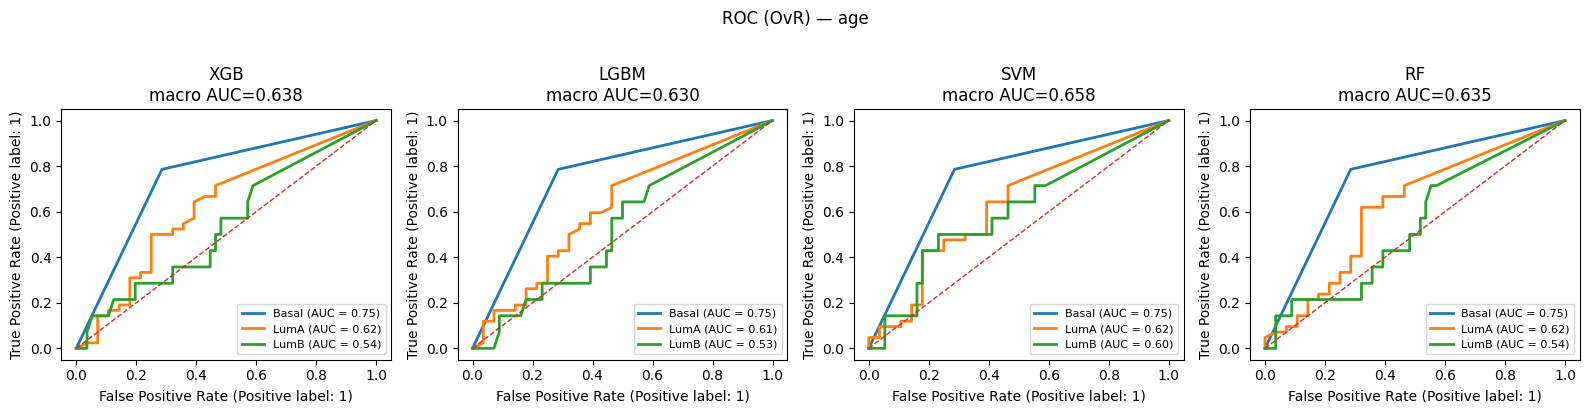

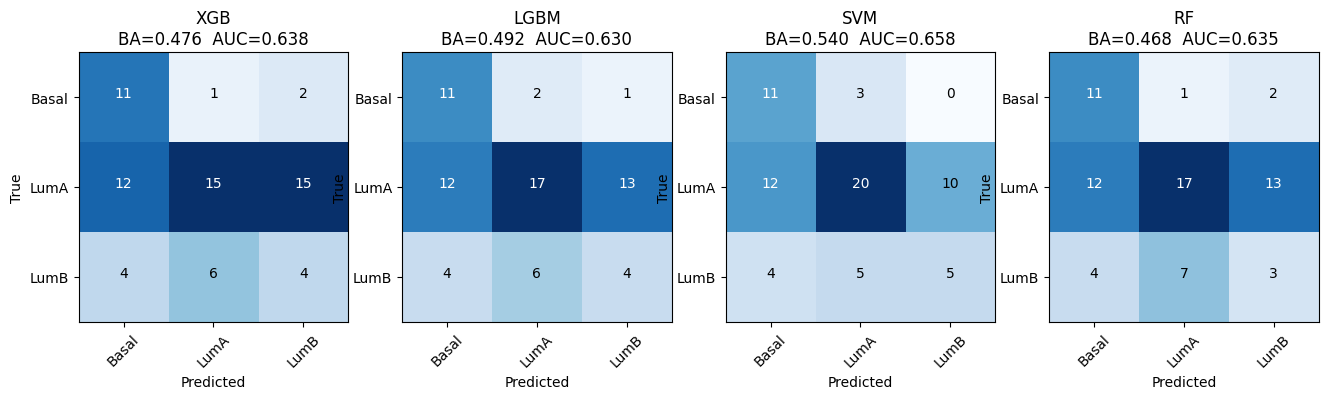

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
SVM           0.493        0.021    0.540     0.658  0.4
LGBM          0.490        0.046    0.492     0.630  0.4
XGB           0.482        0.031    0.476     0.638  0.4
RF            0.472        0.043    0.468     0.635  0.4


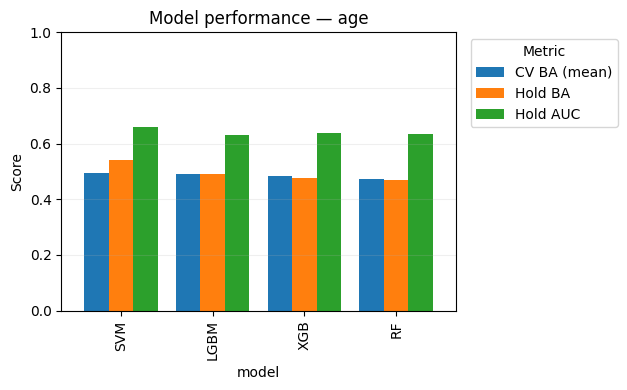


=== Feature set: immune ===

>>> immune + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:28:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.588  HO_BA=0.587  AUC=0.710

>>> immune + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

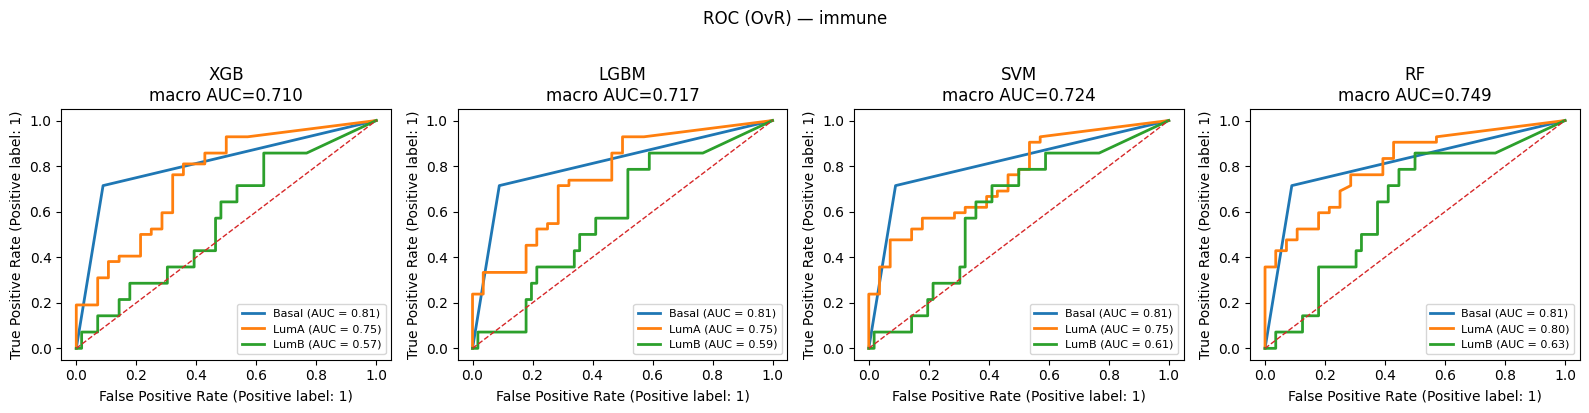

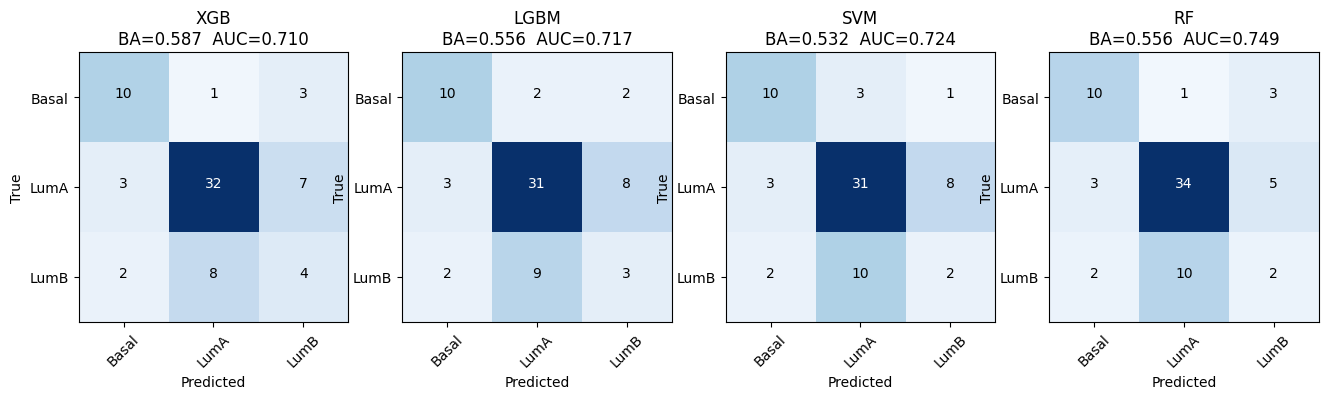

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
XGB           0.588        0.028    0.587     0.710  0.4
LGBM          0.571        0.019    0.556     0.717  0.4
RF            0.581        0.034    0.556     0.749  0.4
SVM           0.582        0.047    0.532     0.724  0.4


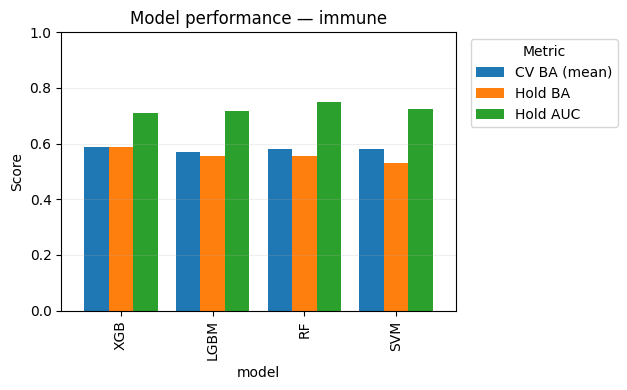


=== Feature set: gene ===

>>> gene + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19380
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:30:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.855  HO_BA=0.897  AUC=0.979

>>> gene + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19380
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

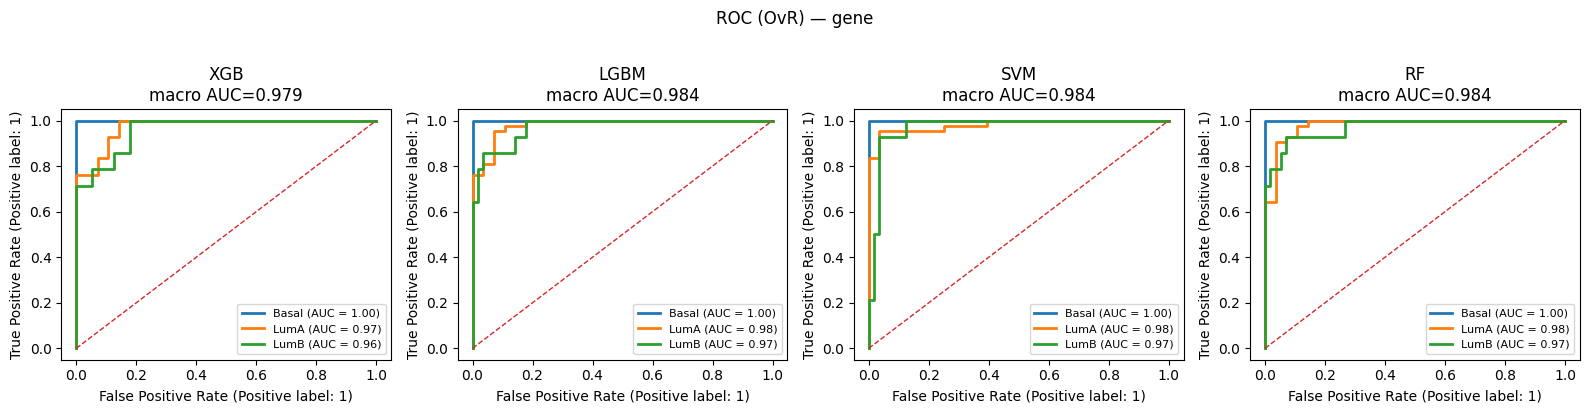

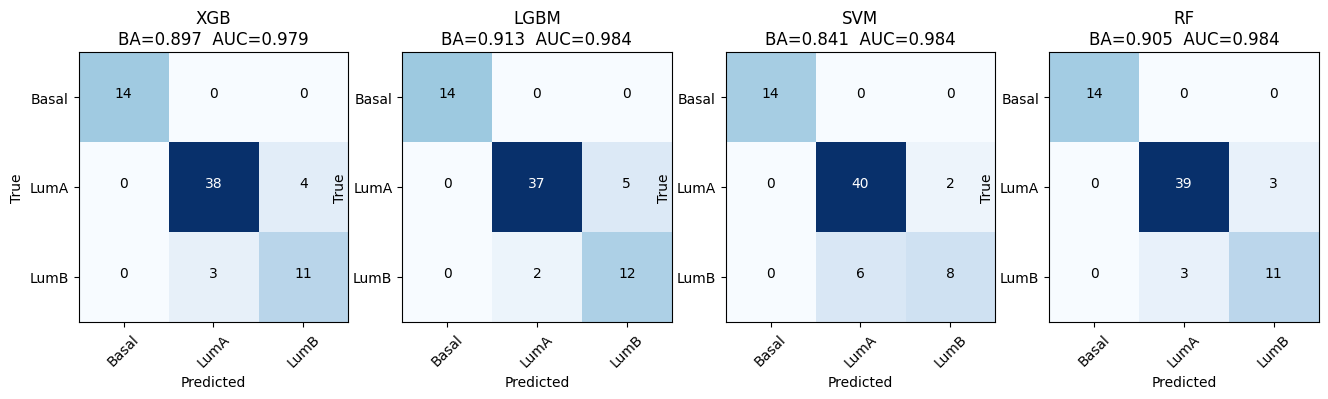

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
LGBM          0.848        0.040    0.913     0.984  0.4
RF            0.843        0.035    0.905     0.984  0.4
XGB           0.855        0.023    0.897     0.979  0.4
SVM           0.778        0.036    0.841     0.984  0.4


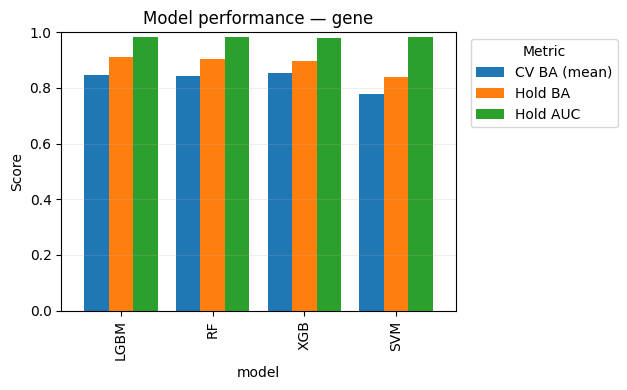


=== Feature set: cpg ===

>>> cpg + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:32:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.50  CV_BA=0.350  HO_BA=0.389  AUC=0.510

>>> cpg + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 375, number of negative: 375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12515
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGB

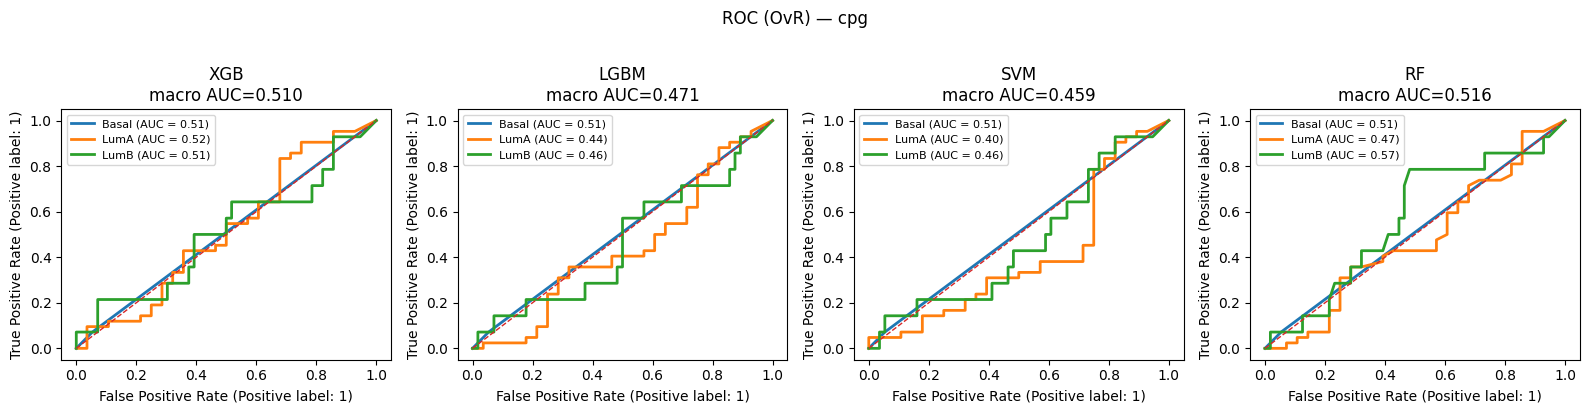

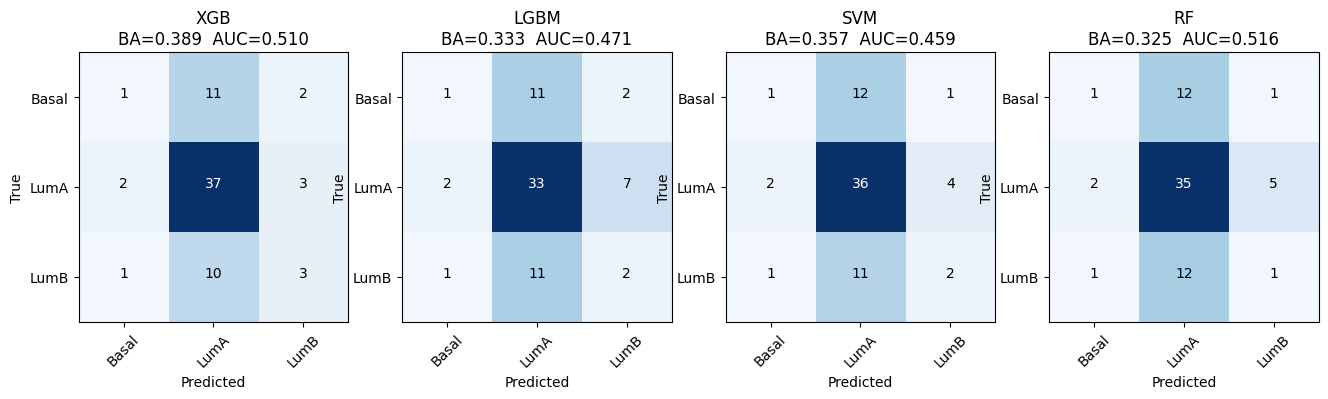

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC   thr
model                                                    
XGB           0.350        0.013    0.389     0.510  0.50
SVM           0.363        0.007    0.357     0.459  0.55
LGBM          0.345        0.031    0.333     0.471  0.50
RF            0.341        0.027    0.325     0.516  0.50


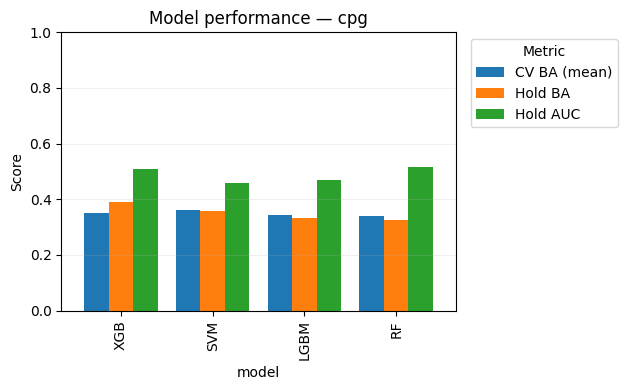


=== Feature set: age_immune ===

>>> age_immune + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4435
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:34:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.655  HO_BA=0.619  AUC=0.777

>>> age_immune + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4435
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

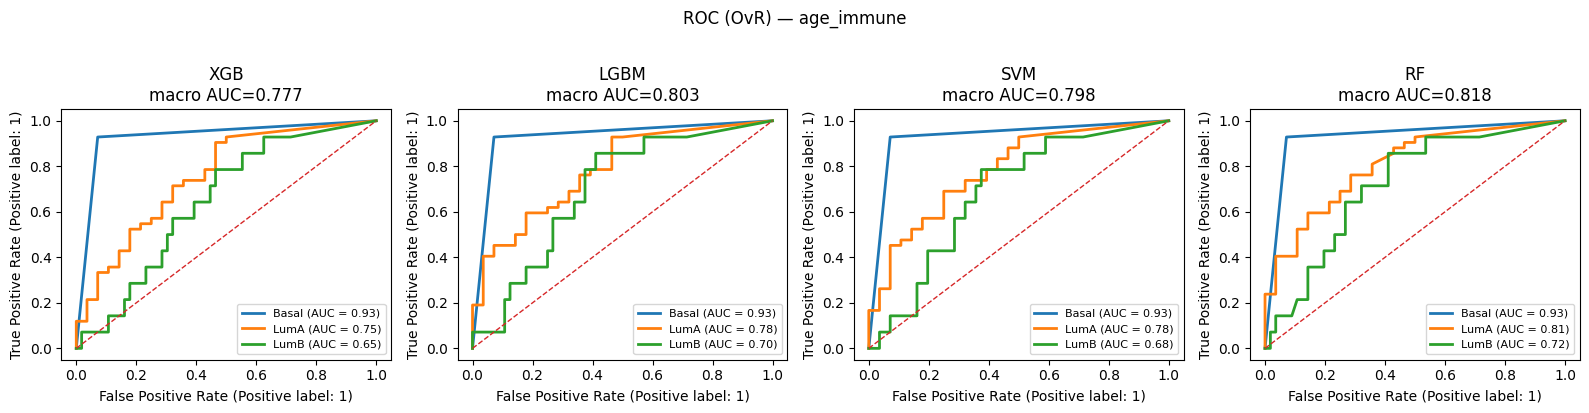

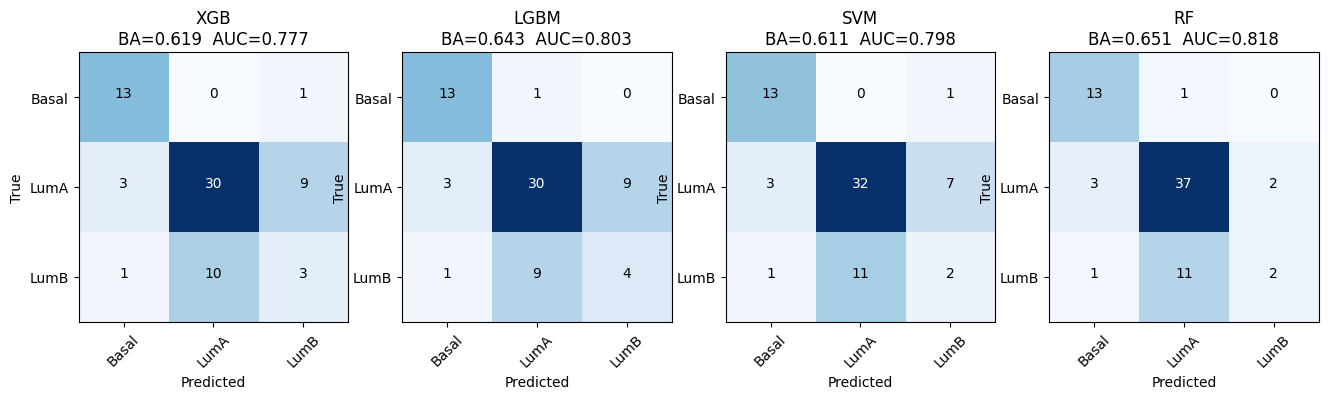

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
RF            0.653        0.040    0.651     0.818  0.4
LGBM          0.647        0.049    0.643     0.803  0.4
XGB           0.655        0.034    0.619     0.777  0.4
SVM           0.654        0.053    0.611     0.798  0.4


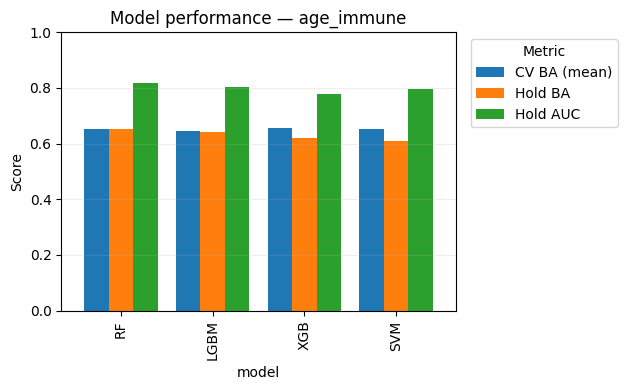


=== Feature set: all ===

>>> all + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36589
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.828  HO_BA=0.873  AUC=0.971

>>> all + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36589
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

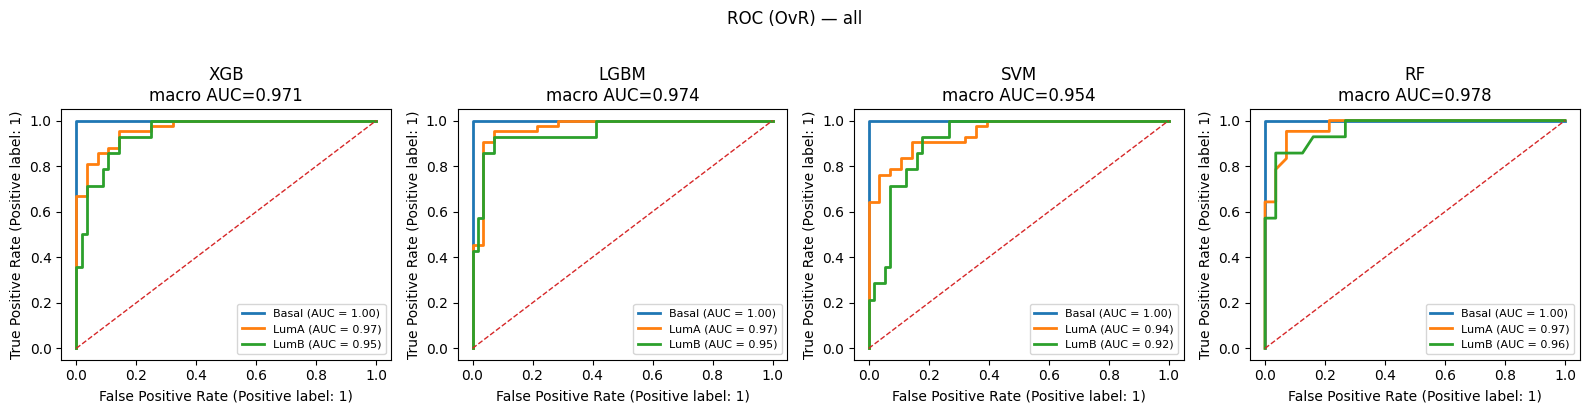

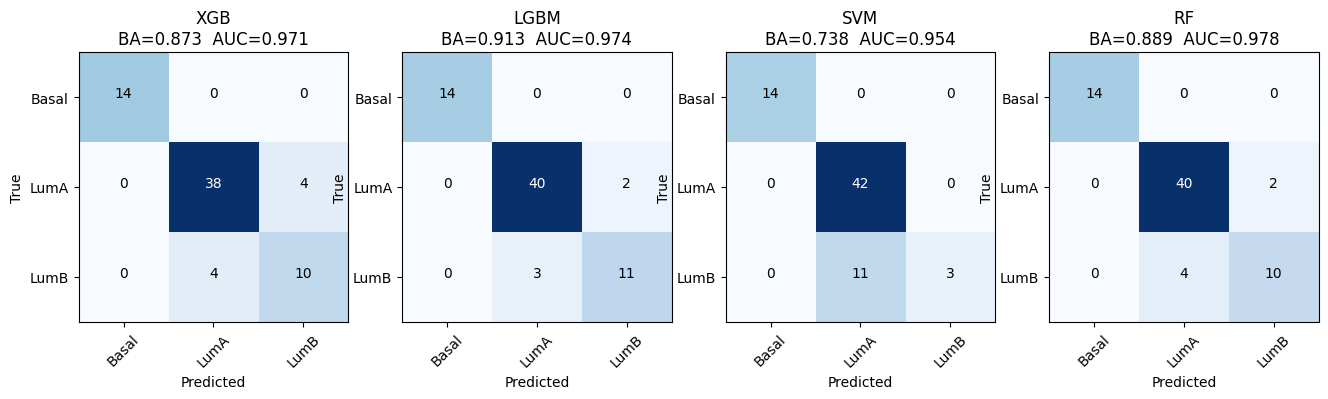

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
LGBM          0.841        0.020    0.913     0.974  0.4
RF            0.829        0.026    0.889     0.978  0.4
XGB           0.828        0.016    0.873     0.971  0.4
SVM           0.762        0.034    0.738     0.954  0.4


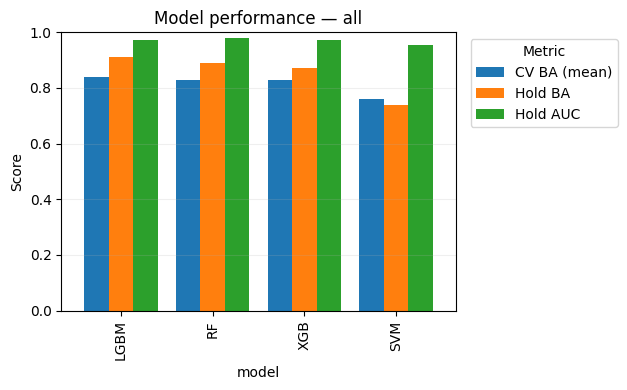

In [ ]:
# ────────────────────────────────────────────────
#  7. Loop: each feature‐set × each fine model
# ────────────────────────────────────────────────
cv  = StratifiedKFold(CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
lbl = ["Basal","LumA","LumB"]
results = {}

rows = []  # local holder reused per feature set

for fs_name, union in X_sets.items():
    print(f"\n=== Feature set: {fs_name} ===")

    # grid of ROC axes, one per model
    fig_roc, axs_roc = plt.subplots(1, len(fine_models),
                                    figsize=(4*len(fine_models), 4),
                                    squeeze=False)

    # confusion matrices grid stays the same
    fig_cm, axs_cm = plt.subplots(1, len(fine_models),
                                  figsize=(4*len(fine_models), 4),
                                  squeeze=False)

    rows = []  # reset for this feature set

    for j, (fm_name, fine_model) in enumerate(fine_models.items()):
        tag = f"{fs_name} + fine={fm_name}"
        print(f"\n>>> {tag}")

        pipe = ImbPipe([
            ("feat", union),
            ("sc"  , StandardScaler()),
            ("sm"  , SMOTE(random_state=RANDOM_STATE)),
            ("clf" , GateAndFine(gate=gate_model,
                                 fine=fine_model,
                                 threshold=0.50))
        ])

        search = GridSearchCV(
            pipe,
            {"clf__threshold": np.linspace(0.40, 0.60, 5)},
            cv=cv, scoring="balanced_accuracy",
            n_jobs=-1, refit=True, verbose=0
        )

        with parallel_backend("threading"):
            search.fit(X_ix[train_idx], y[train_idx])

        best   = search.best_estimator_
        best_i = search.best_index_
        key    = (fs_name, fm_name)
        results[key] = best

        # hold‑out evaluation
        preds = best.predict(X_ix[test_idx])
        prob  = best.predict_proba(X_ix[test_idx])
        ba    = balanced_accuracy_score(y[test_idx], preds)
        aucv  = roc_auc_score(y[test_idx], prob, multi_class="ovr")
        print(f" thr={best.named_steps['clf'].threshold:.2f}  CV_BA={search.best_score_:.3f}  HO_BA={ba:.3f}  AUC={aucv:.3f}")

        # per-class ROC curves on this model's subplot
        ax_roc_m = axs_roc[0, j]
        for k, lab in enumerate(lbl):
            RocCurveDisplay.from_predictions(
                (y[test_idx] == k).astype(int),
                prob[:, k],
                name=lab,
                ax=ax_roc_m,
                linewidth=2
            )
        ax_roc_m.plot([0, 1], [0, 1], "--", lw=1)
        ax_roc_m.set_title(f"{fm_name}\nmacro AUC={aucv:.3f}")
        ax_roc_m.legend(fontsize=8)

        # Confusion matrix
        cm = confusion_matrix(y[test_idx], preds)
        ax_cm = axs_cm[0, j]
        plot_confusion(cm, lbl, f"{fm_name}\nBA={ba:.3f}  AUC={aucv:.3f}", ax_cm)

        # store for summary table
        rows.append({
            "model": fm_name,
            "CV BA (mean)": search.cv_results_["mean_test_score"][best_i],
            "CV BA (std)":  search.cv_results_["std_test_score"][best_i],
            "Hold BA":      ba,
            "Hold AUC":     aucv,
            "thr":          best.named_steps["clf"].threshold
        })

    # finalize per-model ROC grid 
    fig_roc.suptitle(f"ROC (OvR) — {fs_name}", y=1.02)
    fig_roc.tight_layout()
    plt.show()

    fig_cm.suptitle(f"Confusion matrices — {fs_name}", y=1.02)
    fig_cm.tight_layout()
    plt.show()

    # text summary
    df = (pd.DataFrame(rows)
            .set_index("model")
            .round(3)
            .sort_values("Hold BA", ascending=False))
    print(df)

    # grouped bar chart
    metrics = ["CV BA (mean)", "Hold BA", "Hold AUC"]
    metrics = [m for m in metrics if m in df.columns]

    if metrics:
        df_plot = df[metrics]
        fig_bar_w = max(6, 1.6 * len(df_plot))
        ax = df_plot.plot(kind="bar", figsize=(fig_bar_w, 4), width=0.8)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")
        ax.set_title(f"Model performance — {fs_name}")
        ax.grid(axis="y", alpha=0.2)
        ax.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()


### SHAP analysis for one chosen model (robust to shap_values format)

In [ ]:

import numpy as np
import shap
import matplotlib.pyplot as plt

# Map from block name -> original DataFrame (for feature names)
orig = {
    "age":    age,
    "immune": immune,
    "gene":   gene,
    "cpg":    cpg
}

def get_feature_names(union):
    names = []
    for block_name, trans in union.transformer_list:
        top = trans.named_steps["sel"]
        cols = orig[block_name].columns
        keep = cols if top.k is None else cols[top.keep_]
        names += [f"{top.tag}:{c}" for c in keep]
    return np.array(names)


In [ ]:
# Pick model key
model_key = ("all", "XGB")
best_pipe = results[model_key]

In [ ]:
# Extract pipeline pieces
feat_union = best_pipe.named_steps["feat"]
scaler     = best_pipe.named_steps["sc"]
gate_m     = best_pipe.named_steps["clf"].gate_
fine_m     = best_pipe.named_steps["clf"].fine_

In [ ]:
# Recover feature names
feature_names = get_feature_names(feat_union)

In [ ]:
# Build processed train matrices
X_raw       = feat_union.transform(X_ix[train_idx])
X_train     = scaler.transform(X_raw)
lum_mask    = (y[train_idx] != 0)
X_train_fine= X_train[lum_mask]

In [ ]:
# Compute SHAP for Gate
explainer_gate = shap.TreeExplainer(gate_m, feature_perturbation="interventional")
sv_g = explainer_gate.shap_values(X_train)
# if returned as list [neg, pos], pick the positive‐class, else take array
sv_gate = sv_g[1] if isinstance(sv_g, list) else sv_g

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:
# Compute SHAP for Fine
explainer_fine = shap.TreeExplainer(fine_m, feature_perturbation="interventional")
sv_f = explainer_fine.shap_values(X_train_fine)
sv_fine = sv_f[1] if isinstance(sv_f, list) else sv_f

In [ ]:
# Rank & print top‑20
def rank_shap(sv, names, top_k=20):
    mean_abs = np.abs(sv).mean(axis=0)
    idx      = np.argsort(mean_abs)[::-1][:top_k]
    return list(zip(names[idx], mean_abs[idx]))

print("🔹 Top 20 Gate features (Basal vs Luminal):")
for feat, val in rank_shap(sv_gate, feature_names):
    print(f"{feat:30s} {val:.4f}")

print("\n🔹 Top 20 Fine features (LumA vs LumB):")
for feat, val in rank_shap(sv_fine, feature_names):
    print(f"{feat:30s} {val:.4f}")

🔹 Top 20 Gate features (Basal vs Luminal):
gene100:ENSG00000129514.8      2.3397
gene100:ENSG00000115648.14     1.3915
gene100:ENSG00000173467.9      1.2821
gene100:ENSG00000091831.24     1.1718
gene100:ENSG00000100219.16     0.9634
gene100:ENSG00000120262.10     0.8609
gene100:ENSG00000259459.6      0.5269
gene100:ENSG00000148468.17     0.3470
gene100:ENSG00000178935.5      0.1974
gene100:ENSG00000054598.9      0.1925
gene100:ENSG00000187720.14     0.1776
gene100:ENSG00000171428.15     0.1698
gene100:ENSG00000106541.12     0.1614
gene100:ENSG00000168350.8      0.1462
gene100:ENSG00000154548.9      0.1392
gene100:ENSG00000206113.11     0.1245
gene100:ENSG00000172425.12     0.1164
gene100:ENSG00000259725.1      0.0941
gene100:ENSG00000160180.15     0.0936
gene100:ENSG00000253125.1      0.0759

🔹 Top 20 Fine features (LumA vs LumB):
gene100:ENSG00000054598.9      0.8544
gene100:ENSG00000186832.9      0.7347
gene100:ENSG00000005513.10     0.5920
gene100:ENSG00000198729.5      0.5001
gene1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19248\2492277045.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_gate,   X_train,      feature_names=feature_names, plot_type="bar")


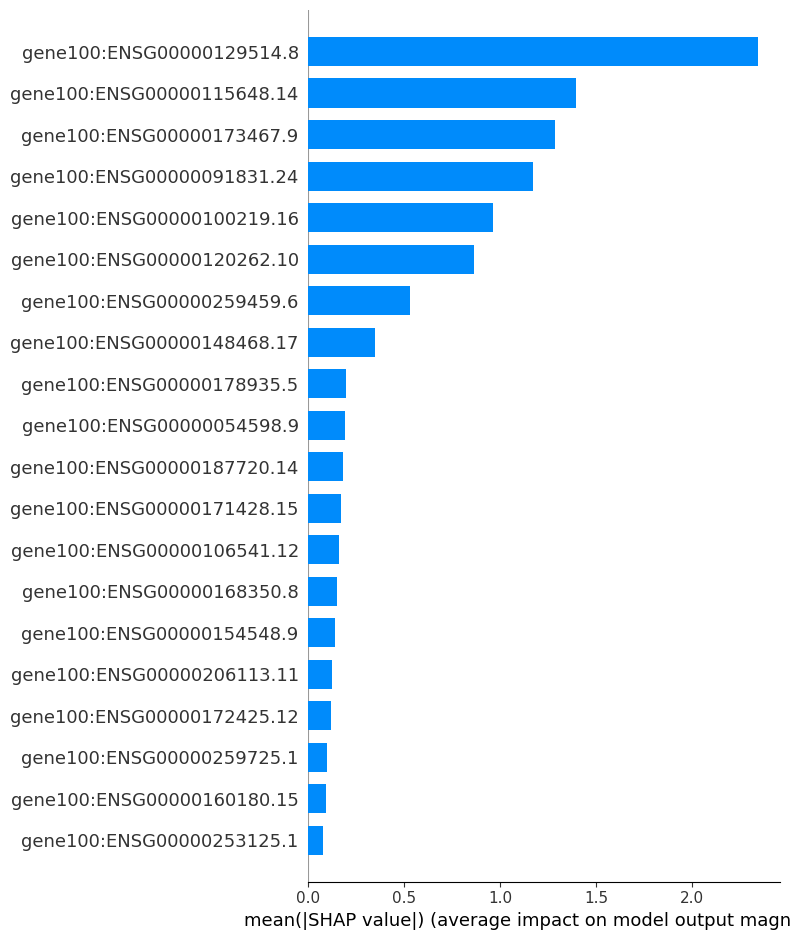

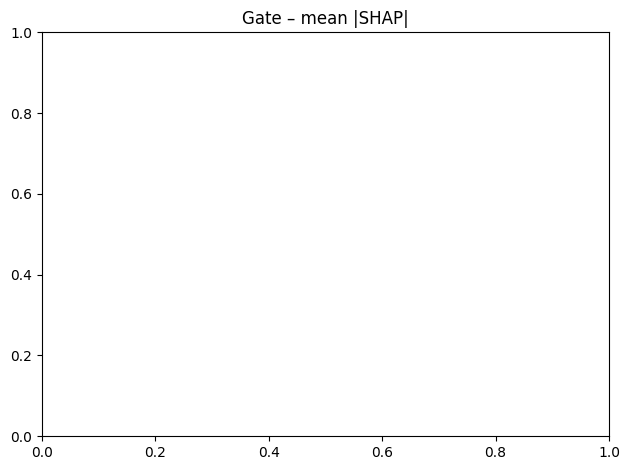

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19248\2492277045.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_fine,   X_train_fine, feature_names=feature_names, plot_type="bar")


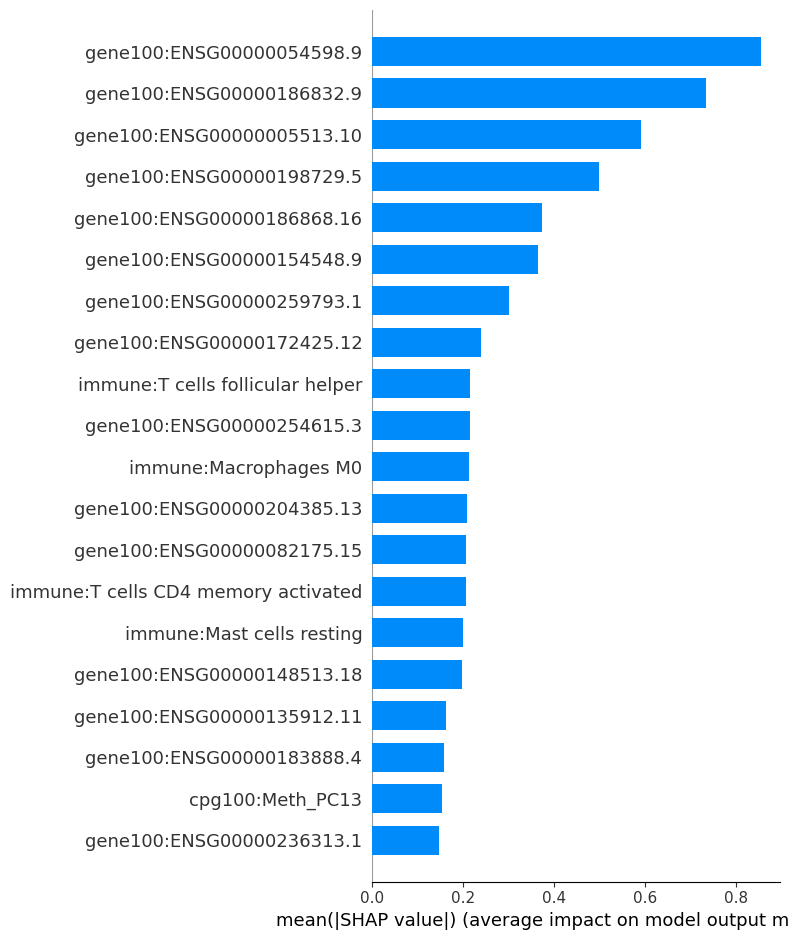

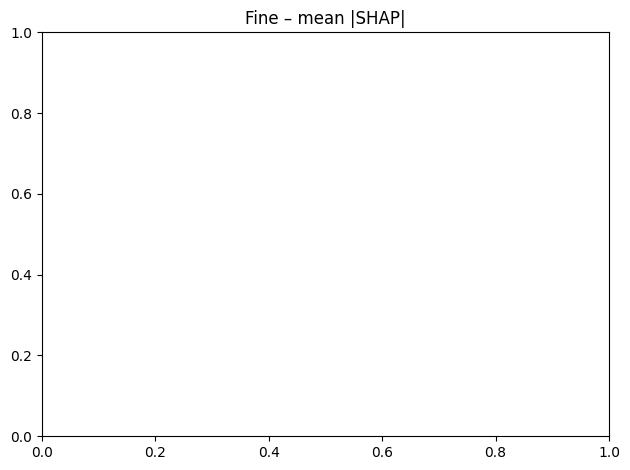

In [ ]:
# SHAP summary bar plots
shap.summary_plot(sv_gate,   X_train,      feature_names=feature_names, plot_type="bar")
plt.title("Gate – mean |SHAP|");   plt.tight_layout(); plt.show()
shap.summary_plot(sv_fine,   X_train_fine, feature_names=feature_names, plot_type="bar")
plt.title("Fine – mean |SHAP|");   plt.tight_layout(); plt.show()

Plotting SHAP dependence for: gene100:ENSG00000129514.8


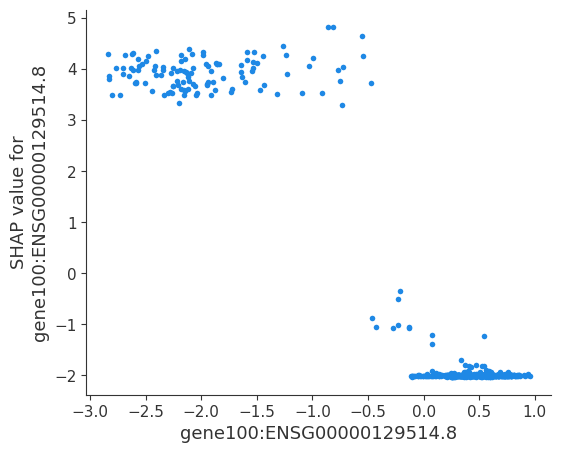

In [24]:
# 1) Recompute the Top‑20 list for Gate (if you didn’t save it):
top20_gate = rank_shap(sv_gate, feature_names, top_k=20)

# 2) Pick the very top feature name:
feat = top20_gate[0][0]   # e.g. "gene100:TP53"

print("Plotting SHAP dependence for:", feat)

# 3) Dependence plot (shows how that feature’s value drives its SHAP):
import shap
shap.dependence_plot(
    feat,
    sv_gate,
    X_train,
    feature_names=feature_names,
    interaction_index=None  # or another feature name to color by interactions
)


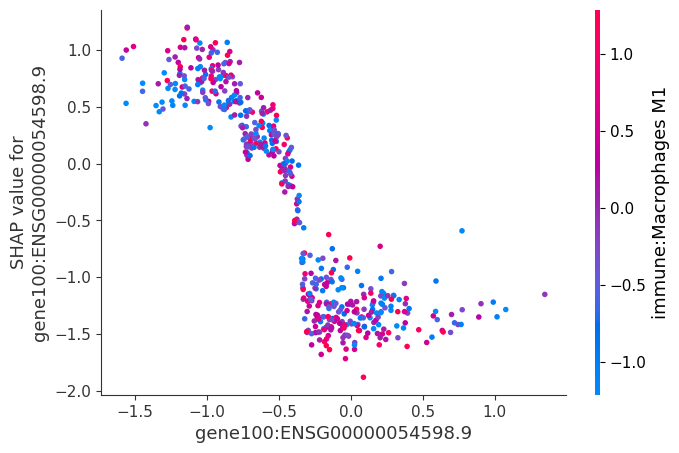

In [25]:
top20_fine = rank_shap(sv_fine, feature_names, top_k=20)
feat2 = top20_fine[0][0]
shap.dependence_plot(feat2, sv_fine, X_train_fine, feature_names=feature_names)
